In [1]:
%load_ext autoreload
%autoreload 2

In [139]:
from os import path
import tempfile

import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%matplotlib inline

In [140]:
em_client = EMClient.init_microns()

In [141]:
cell_type_table = em_client.get_cell_type_table()
cell_type_table.head()

,index,id_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,valid,target_id,classification_system,cell_type,pt_position,bb_start_position,bb_end_position,position_microns
0,0,498173,t,308.176159,103884538719281829,864691136091295156,553,t,498173,aibs_neuronal,6P-IT,"[1138752.0, 847744.0, 622640.0]","[nan, nan, nan]","[nan, nan, nan]","[1060.532946861501, 547.0958222941854, 622.640..."
1,1,487329,t,295.937638,105279407463397326,864691135975935434,4509,t,487329,aibs_neuronal,MC,"[1178176.0, 474496.0, 869800.0]","[nan, nan, nan]","[nan, nan, nan]","[1132.3376333081478, 178.7041716229213, 869.80..."
2,2,106662,t,230.148178,79524515478544304,864691136084076652,4693,t,106662,aibs_neuronal,23P,"[428224.0, 476992.0, 776560.0]","[nan, nan, nan]","[nan, nan, nan]","[385.0218863509487, 115.82805000426656, 776.56..."
3,3,271350,t,305.328128,87351114324194368,864691135937342005,5061,t,271350,aibs_neuronal,6P-CT,"[655680.0, 943872.0, 835000.0]","[nan, nan, nan]","[nan, nan, nan]","[570.9210744260782, 600.755527271752, 835.0000..."
4,4,456040,t,257.463910,101129507251445952,864691136084057196,8652,t,456040,aibs_neuronal,MC,"[1058176.0, 530112.0, 959520.0]","[nan, nan, nan]","[nan, nan, nan]","[1007.9470157484845, 223.64984682227282, 959.5..."


In [142]:
cell_type_table.cell_type.value_counts()

23P          17823
4P           13052
6P-IT        10225
5P-IT         8673
astrocyte     6889
6P-CT         5506
oligo         4900
BC            2968
microglia     2718
MC            2195
OPC           1693
5P-ET         1460
BPC           1389
NGC            596
pericyte       539
5P-NP          442
Name: cell_type, dtype: int64

In [14]:
proof_table = em_client.query_table("proofreading_status_public_release")
proof_table["dendrite_complete"] = proof_table.status_dendrite.isin(["clean", "extended"])
proof_table["axon_complete"] = proof_table.status_axon.isin(["extended"])
proof_table

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position,dendrite_complete,axon_complete
0,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[765696.0, 839552.0, 913800.0]",True,False
1,7,t,91570559116360958,864691136602027473,864691136602027473,extended,non,"[779456.0, 864512.0, 888200.0]",True,False
2,8,t,90444453118345856,864691135866846742,864691135866846742,extended,non,"[747072.0, 857152.0, 912440.0]",True,False
3,9,t,89741246779911895,864691135445832338,864691135445832338,extended,non,"[725248.0, 871616.0, 930040.0]",True,False
4,13,t,91499640750531825,864691135569255558,864691135569255558,extended,non,"[776448.0, 848256.0, 927000.0]",True,False
...,...,...,...,...,...,...,...,...,...,...
759,870,t,90518464128858597,864691136594839202,864691136594839202,clean,clean,"[747712.0, 966976.0, 948720.0]",True,False
760,871,t,91712464970366508,864691136175508486,864691136175508486,clean,clean,"[782976.0, 898432.0, 940000.0]",True,False
761,736,t,110706459687342783,864691136617461979,864691136617461979,extended,extended,"[1335552.0, 733184.0, 943920.0]",True,True
762,154,t,89456404347350172,864691135334665705,864691135334665705,extended,non,"[717824.0, 771840.0, 863120.0]",True,False


In [91]:
root_id_to_cell_type = pd.Series(index=cell_type_table.pt_root_id.values, data=cell_type_table.cell_type.values)

In [17]:
proof_axon_root_ids = proof_table.pt_root_id.values[proof_table.axon_complete]
print(f"{len(proof_axon_root_ids)} cells have proofread axons")

cell_type_table[cell_type_table.pt_root_id.isin(proof_axon_root_ids)].cell_type.value_counts()

289 cells have proofread axons


BC       77
MC       52
BPC      33
5P-IT    28
23P      28
5P-ET    21
4P       20
NGC       9
6P-IT     4
6P-CT     4
Name: cell_type, dtype: int64

In [119]:
n = 20
mc_root_ids = cell_type_table[cell_type_table.pt_root_id.isin(proof_axon_root_ids) & (cell_type_table.cell_type == "MC")].pt_root_id.values[:n]
bc_root_ids = cell_type_table[cell_type_table.pt_root_id.isin(proof_axon_root_ids) & (cell_type_table.cell_type == "BC")].pt_root_id.values[:n]
bpc_root_ids = cell_type_table[cell_type_table.pt_root_id.isin(proof_axon_root_ids) & (cell_type_table.cell_type == "BPC")].pt_root_id.values[:n]
pyc_root_ids = cell_type_table[cell_type_table.pt_root_id.isin(proof_axon_root_ids) & (cell_type_table.cell_type.isin(["23P", "4P"]))].pt_root_id.values[:n]

In [105]:
euc_dist_fn = lambda a, b: np.linalg.norm(a[::2] - b[::2])
horiz_dist_fn = lambda a, b: np.linalg.norm(a - b)

In [106]:
mc_syn = em_client.get_axonal_synapses(mc_root_ids)
# mc_syn["soma_soma_dist"] = mc_syn.apply(lambda row: None if row["post_soma_position_microns"] is None else horiz_dist_fn(row["pre_soma_position_microns"], row["post_soma_position_microns"]), axis=1)


In [120]:
pyc_syn = em_client.get_axonal_synapses(pyc_root_ids)

In [107]:
bc_syn = em_client.get_axonal_synapses(bc_root_ids)
bpc_syn = em_client.get_axonal_synapses(bpc_root_ids)

In [121]:
is_exc_postsyn = lambda syn: syn.post_pt_root_id.apply(lambda post: root_id_to_cell_type.get(post, default=None) in em_client.exc_cell_types)
mc_syn_postsoma_dist = mc_syn[is_exc_postsyn(mc_syn)].apply(lambda row: None if row["post_soma_position_microns"] is None else euc_dist_fn(row["synapse_position_microns"], row["post_soma_position_microns"]), axis=1)
bc_syn_postsoma_dist = bc_syn[is_exc_postsyn(bc_syn)].apply(lambda row: None if row["post_soma_position_microns"] is None else euc_dist_fn(row["synapse_position_microns"], row["post_soma_position_microns"]), axis=1)
bpc_syn_postsoma_dist = bpc_syn[is_exc_postsyn(bpc_syn)].apply(lambda row: None if row["post_soma_position_microns"] is None else euc_dist_fn(row["synapse_position_microns"], row["post_soma_position_microns"]), axis=1)
pyc_syn_postsoma_dist = pyc_syn[is_exc_postsyn(pyc_syn)].apply(lambda row: None if row["post_soma_position_microns"] is None else euc_dist_fn(row["synapse_position_microns"], row["post_soma_position_microns"]), axis=1)

In [130]:
# Brain observatory colors
# MC_COLOR = "#7B5217" # brown
# BC_COLOR = "#DE5F0D" # orange
# BPC_COLOR = "#B49139" # muted gold

MC_COLOR = "#DE5F0D" # orange
BC_COLOR = "royalblue"
BPC_COLOR = "#B49139"

# EXC:
# "#a92e66" # red/purple
# "#6D677E"
# "#A19DAF"
# "#7841be" # purple
EXC_COLOR = "#5CAD53" # green
# EXC_COLOR = "#7841BE" # purple

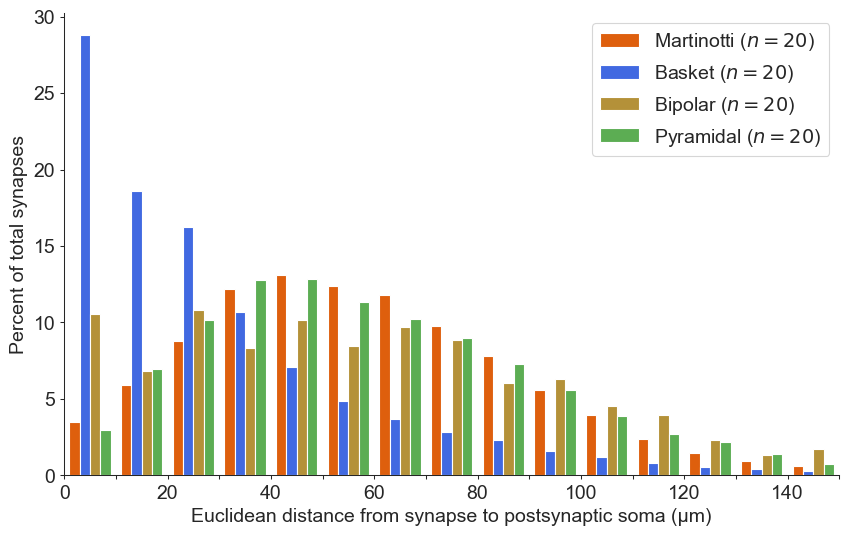

In [131]:
fig, ax = plt.subplots(figsize=(10, 6))
bin_width = 10
xmax = 150
bins = np.arange(0, xmax+bin_width, bin_width)

ax.hist([mc_syn_postsoma_dist, bc_syn_postsoma_dist, bpc_syn_postsoma_dist, pyc_syn_postsoma_dist], bins=bins, color=[MC_COLOR, BC_COLOR, BPC_COLOR, EXC_COLOR], density=True, label=[f"Martinotti ($n = {len(mc_root_ids)}$)", f"Basket ($n = {len(bc_root_ids)}$)", f"Bipolar ($n = {len(bpc_root_ids)}$)", f"Pyramidal ($n = {len(pyc_root_ids)}$)"])
ax.set_xlim(0, xmax)
yticks = ax.get_yticks()[:-1]
ax.set_yticks(ticks=yticks, labels=[f"{y*bin_width*100:.0f}" for y in yticks], fontsize=14)
ax.set_xticks(ticks=bins, labels=[bins[i] if i % 2 == 0 else "" for i in range(0, len(bins))], fontsize=14)
ax.set_xlabel("Euclidean distance from synapse to postsynaptic soma (µm)", fontsize=14)
ax.set_ylabel("Percent of total synapses", fontsize=14)
ax.legend(fontsize=14, bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

Text(0, 0.5, 'Synapse dist to postsyn. soma (µm)')

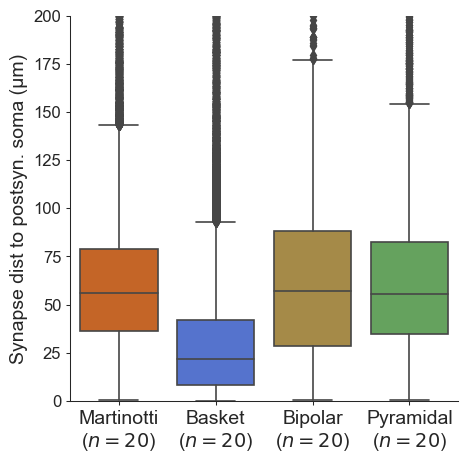

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))
# sns.violinplot(data=[mc_syn_postsoma_dist, bc_syn_postsoma_dist, bpc_syn_postsoma_dist], palette=[MC_COLOR, BC_COLOR, BPC_COLOR], ax=ax)
# sns.violinplot(data=[mc_syn_postsoma_dist, bc_syn_postsoma_dist, bpc_syn_postsoma_dist, pyc_syn_postsoma_dist], palette=[MC_COLOR, BC_COLOR, BPC_COLOR, EXC_COLOR], ax=ax)
sns.boxplot(data=[mc_syn_postsoma_dist, bc_syn_postsoma_dist, bpc_syn_postsoma_dist, pyc_syn_postsoma_dist], palette=[MC_COLOR, BC_COLOR, BPC_COLOR, EXC_COLOR], ax=ax)
ax.set_ylim(0, 200)
# ax.set_xticklabels(["Martinotti", "Basket", "Bipolar"], fontsize=14)
# ax.set_xticklabels([f"Martinotti\n($n = {len(mc_root_ids)}$)", f"Basket\n($n = {len(bc_root_ids)}$)", f"Bipolar\n($n = {len(bpc_root_ids)}$)"], fontsize=14)
ax.set_xticklabels([
    f"Martinotti\n($n = {len(mc_root_ids)}$)",
    f"Basket\n($n = {len(bc_root_ids)}$)",
    f"Bipolar\n($n = {len(bpc_root_ids)}$)",
    f"Pyramidal\n($n = {len(pyc_root_ids)}$)"
    ], fontsize=14)
ax.set_ylabel("Synapse dist to postsyn. soma (µm)", fontsize=14)